# Part 1 : Baseline Model

In [2]:
# Imports
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [3]:
# Loading data
data_files = ["../data/data0.npy", "../data/data1.npy", "../data/data2.npy"]
label_files = ["../data/lab0.npy", "../data/lab1.npy", "../data/lab2.npy"]

data = [np.load(file) for file in data_files]
label = [np.load(file) for file in label_files]

images = np.concatenate(data)
labels = np.concatenate(label)

In [8]:
# Data -> Dataloader
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.float32)


# Image Transform
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, train_size=0.85, random_state=42)
batch_size = 64
train_dataset = CustomDataset(train_images, train_labels, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = CustomDataset(test_images, test_labels, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [27]:
# Saving test dataloader for inference
torch.save(test_dataset, "test_dataset.pth")

In [5]:
# Setting up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Baseline CNN Model Architecture
class BaselineCNN(nn.Module):
    def __init__(self, num_classes=1):
        super(BaselineCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*420, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

### Regression Approach
- Directly predict a sum using the trained model
- Model output can be any real number
- MSE Loss used

In [16]:
model_reg = BaselineCNN(num_classes=1).to(device)
criterion_reg = nn.MSELoss()
optimizer_reg = optim.Adam(model_reg.parameters(), lr=0.001)

In [19]:
def train_regression(dataloader):
    model_reg.train()
    loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer_reg.zero_grad()
        outputs = model_reg(images)
        loss = criterion_reg(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer_reg.step()
        loss += loss.item()
    return loss

In [20]:
# Training Loop
num_epochs = 50
train_loss_reg = []
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    train_loss = train_regression(train_dataloader)
    train_loss_reg.append(train_loss.item())
    if (epoch+1)%5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")

Epochs:  10%|█         | 5/50 [01:08<10:15, 13.68s/it]

Epoch [5/50], Train Loss: 7.3178


Epochs:  20%|██        | 10/50 [02:16<09:03, 13.59s/it]

Epoch [10/50], Train Loss: 4.7164


Epochs:  30%|███       | 15/50 [03:23<07:54, 13.55s/it]

Epoch [15/50], Train Loss: 2.3658


Epochs:  40%|████      | 20/50 [04:32<06:49, 13.63s/it]

Epoch [20/50], Train Loss: 1.6576


Epochs:  50%|█████     | 25/50 [05:41<05:42, 13.71s/it]

Epoch [25/50], Train Loss: 0.9492


Epochs:  60%|██████    | 30/50 [06:48<04:32, 13.61s/it]

Epoch [30/50], Train Loss: 0.7746


Epochs:  70%|███████   | 35/50 [07:57<03:24, 13.64s/it]

Epoch [35/50], Train Loss: 0.8789


Epochs:  80%|████████  | 40/50 [09:05<02:16, 13.62s/it]

Epoch [40/50], Train Loss: 0.3981


Epochs:  90%|█████████ | 45/50 [10:13<01:08, 13.67s/it]

Epoch [45/50], Train Loss: 0.6390


Epochs: 100%|██████████| 50/50 [11:21<00:00, 13.64s/it]

Epoch [50/50], Train Loss: 0.4777


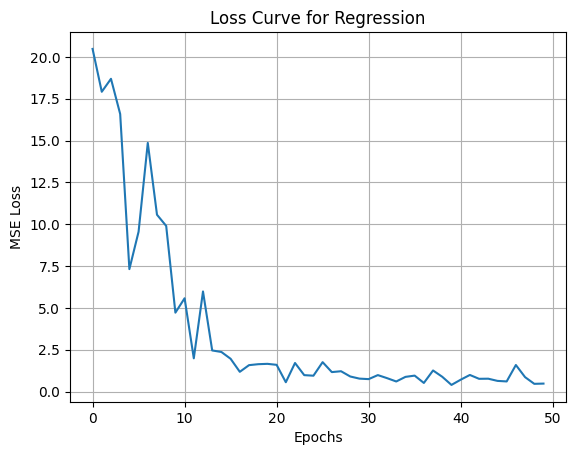

In [21]:
# Loss Curve
plt.figure()
plt.plot(range(num_epochs), train_loss_reg, label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Loss Curve for Regression")
plt.grid(True)
plt.show()

In [22]:
# Saving trained model
torch.save(model_reg.state_dict(), "models/baseline_cnn_reg.pth")

### Classification Approach
- Predict the sum from a set of 37 distinct classes (0-36)
- Model output will be a value from one of the classes
- Cross Entropy Loss used

In [31]:
model_clf = BaselineCNN(num_classes=37).to(device)
criterion_clf = nn.CrossEntropyLoss()
optimizer_clf = optim.Adam(model_clf.parameters(), lr=0.001)

In [24]:
def train_classification(dataloader):
    model_clf.train()
    loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer_clf.zero_grad()
        outputs = model_clf(images)
        loss = criterion_clf(outputs, labels.long())
        loss.backward()
        optimizer_clf.step()
        loss += loss.item()
    return loss

In [32]:
# Training Loop
num_epochs = 50
train_loss_clf = []
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    train_loss = train_classification(train_dataloader)
    train_loss_clf.append(train_loss.item())
    if (epoch+1)%5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")

Epochs:  10%|█         | 5/50 [01:08<10:17, 13.71s/it]

Epoch [5/50], Train Loss: 4.5599


Epochs:  20%|██        | 10/50 [02:17<09:10, 13.76s/it]

Epoch [10/50], Train Loss: 1.1923


Epochs:  30%|███       | 15/50 [03:25<07:55, 13.59s/it]

Epoch [15/50], Train Loss: 0.6948


Epochs:  40%|████      | 20/50 [04:33<06:50, 13.68s/it]

Epoch [20/50], Train Loss: 0.3421


Epochs:  50%|█████     | 25/50 [05:41<05:39, 13.57s/it]

Epoch [25/50], Train Loss: 0.0878


Epochs:  60%|██████    | 30/50 [06:49<04:30, 13.54s/it]

Epoch [30/50], Train Loss: 0.0390


Epochs:  70%|███████   | 35/50 [07:57<03:24, 13.62s/it]

Epoch [35/50], Train Loss: 0.0014


Epochs:  80%|████████  | 40/50 [09:06<02:17, 13.71s/it]

Epoch [40/50], Train Loss: 0.0003


Epochs:  90%|█████████ | 45/50 [10:13<01:07, 13.53s/it]

Epoch [45/50], Train Loss: 0.0001


Epochs: 100%|██████████| 50/50 [11:21<00:00, 13.63s/it]

Epoch [50/50], Train Loss: 0.0000


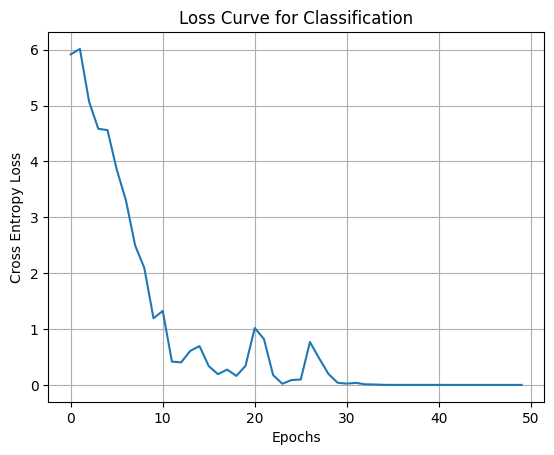

In [33]:
# Loss Curve
plt.figure()
plt.plot(range(num_epochs), train_loss_clf, label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.title("Loss Curve for Classification")
plt.grid(True)
plt.show()

In [35]:
# Saving trained model
torch.save(model_clf.state_dict(), "models/baseline_cnn_clf.pth")